# Геннадий Балан

# Домашняя работа по Машинному обучению в бизнесе № 2

# Тема: Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#¶

##### Задача 1
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [9]:
import pandas as pd
import numpy as np
from gensim.corpora.dictionary import Dictionary # установили заранее
import re
import nltk
from nltk.corpus import stopwords
import pymorphy2 # установили заранее
from razdel import tokenize

In [10]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [11]:
users = pd.read_csv("users_articles_lesson2.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [12]:
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gennady\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

FileNotFoundError: [Errno 2] No such file or directory: 'stopwords.txt'

In [15]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [16]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-15-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 46.9 s


In [96]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 7min 40s


In [ ]:
ОБУЧЕНИЕ МОДЕЛИ

In [97]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [98]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Создать корпус из списка текстов
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [57]:
common_dictionary[10]

'ватутин'

In [11]:
common_dictionary[4]

'армеец'

In [99]:
%%time
from gensim.models import LdaModel
# Тренируйте модель на корпусе.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 36s


In [59]:
from gensim.test.utils import datapath
# Сохраните модель на диск.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Загрузите потенциально предварительно подготовленную модель с диска
lda = LdaModel.load(temp_file)

In [ ]:
Модель обучена

In [100]:
# Создайте новый корпус, состоящий из ранее невиданных документов.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.10292443),
 (1, 0.44430834),
 (8, 0.086506255),
 (14, 0.087592855),
 (15, 0.08304061),
 (20, 0.08658612),
 (23, 0.09292267)]

In [101]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Ниже Кода Печатаются Только Слова
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год nn статья который тыс рубль человек
topic_1: это мочь всё который очень первый весь
topic_2: это который свой человек мочь год время
topic_3: газ смерть квартира дом городской долг область
topic_4: экипаж северный японский южный япония продолжительность энергия
topic_5: украина украинский год россия это президент путин
topic_6: лаборатория озеро испания испанский италия исследование дания
topic_7: год россия который проект российский компания банк
topic_8: китай китайский продукция свет это эволюция свидетель
topic_9: год млрд млн рубль составить доход бюджет
topic_10: обнаружить суд тело дело препарат остров помощь
topic_11: год земля город день который это предполагать
topic_12: ребёнок это женщина газета nn человек семья
topic_13: год напомнить это хороший снизить всё день
topic_14: американский сша год доллар который температура это
topic_15: это год который мочь новый весь цена
topic_16: год способность падение учреждение который бизнесмен сократиться
topic_17: дыра б

In [ ]:
Есть изъяны ,типа nn

In [102]:
def get_lda_vector(text): # функция, которая будет нам возвращать векторное представление новости
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [103]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.000000,0.0,0.0,0.011556,0.0,0.895849,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.074102,0.0000,0.0,0.000000,0.0
1,4896,0.000000,0.115771,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.5047,0.0,0.172614,0.0
2,4897,0.102747,0.444394,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.086595,...,0.083125,0.0,0.0,0.0,0.0,0.086103,0.0000,0.0,0.092943,0.0
3,4898,0.000000,0.494590,0.000000,0.0,0.0,0.000000,0.0,0.084888,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0
4,4899,0.000000,0.000000,0.297553,0.0,0.0,0.141549,0.0,0.410362,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.127133,0.0000,0.0,0.000000,0.0


In [ ]:
Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

In [ ]:
Векторные представления пользователей

In [104]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [105]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [106]:
doc_dict[293126]

array([0.        , 0.        , 0.24507642, 0.        , 0.        ,
       0.07186368, 0.        , 0.        , 0.        , 0.        ,
       0.11110554, 0.11101591, 0.17425624, 0.        , 0.19793448,
       0.        , 0.        , 0.        , 0.07199184, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [68]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list): # в user_vector изменили среднее значение на медиану
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [69]:
get_user_embedding(user_articles_list)

array([0.01122396, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.06002676, 0.        , 0.02939036,
       0.        , 0.        , 0.14236967, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.13135594,
       0.        , 0.        , 0.0236214 , 0.        , 0.        ])

In [ ]:
Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [70]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.030260,0.0,...,0.0,0.0,0.0,0.000000,0.133357,0.0,0.000000,0.000000,0.000000,0.000000
1,u108690,0.021886,0.0,0.0,0.0,0.005074,0.020415,0.00000,0.038260,0.0,...,0.0,0.0,0.0,0.027994,0.104644,0.0,0.017571,0.125490,0.011698,0.036787
2,u108339,0.039312,0.0,0.0,0.0,0.000000,0.078534,0.01765,0.005484,0.0,...,0.0,0.0,0.0,0.025124,0.094009,0.0,0.028499,0.047018,0.000000,0.187674


In [ ]:
Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [71]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [72]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.030260,0.0,...,0.0,0.0,0.000000,0.133357,0.0,0.000000,0.000000,0.000000,0.000000,0
1,u108690,0.021886,0.0,0.0,0.0,0.005074,0.020415,0.00000,0.038260,0.0,...,0.0,0.0,0.027994,0.104644,0.0,0.017571,0.125490,0.011698,0.036787,1
2,u108339,0.039312,0.0,0.0,0.0,0.000000,0.078534,0.01765,0.005484,0.0,...,0.0,0.0,0.025124,0.094009,0.0,0.028499,0.047018,0.000000,0.187674,1


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

%matplotlib inline

In [74]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [75]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [76]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.15585127, 0.00873421, 0.39318681, 0.23751865, 0.07570146,
       0.03803976, 0.14184837, 0.05931144, 0.01585113, 0.13142899])

In [77]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#### Рассчитаем Precision, Recall, F_score¶

In [78]:
import itertools

In [79]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# Найдём индекс наибольшего f-score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.281765, F-Score=0.850, Precision=0.832, Recall=0.869


In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1712   43]
 [  33  212]]


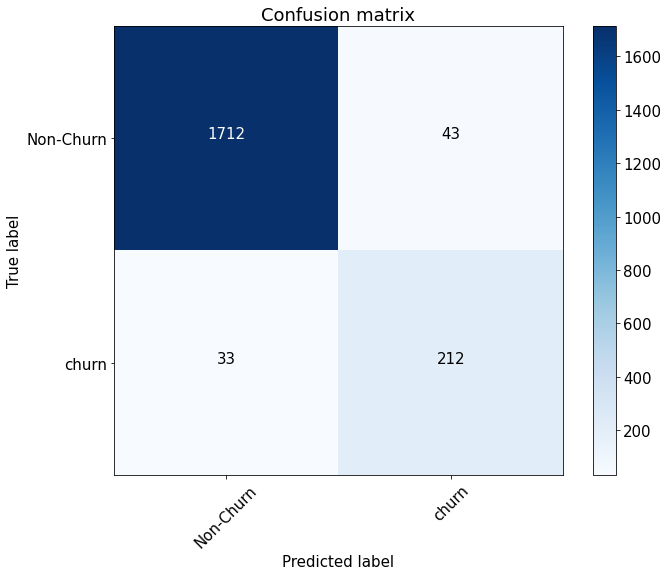

In [81]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [82]:
roc_auc_score(y_test, preds)

0.9865178208035351

##### Задание 3
Повторить п.2, но используя уже не медиану, а max

In [107]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list): # в user_vector изменили среднее значение на медиану
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.amax(user_vector, 0)
    return user_vector

In [108]:
get_user_embedding(user_articles_list)

array([0.62362194, 0.04705328, 0.35538048, 0.        , 0.        ,
       0.57455945, 0.01112637, 0.21331303, 0.02135526, 0.05455374,
       0.        , 0.06137491, 0.49294794, 0.05034477, 0.11370514,
       0.28535232, 0.04281921, 0.        , 0.271198  , 0.        ,
       0.05439617, 0.32524094, 0.02530176, 0.        , 0.17484103])

In [ ]:
Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [109]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.140536,0.024149,0.245076,0.000000,0.077579,0.683476,0.0,0.491359,0.055958,...,0.069217,0.000000,0.000000,0.200244,0.0,0.000000,0.123538,0.000000,0.088765,0.047885
1,u108690,0.139602,0.208270,0.288622,0.021252,0.012601,0.319381,0.0,0.086272,0.010270,...,0.144577,0.000000,0.045807,0.179659,0.0,0.027672,0.245884,0.010754,0.000000,0.030331
2,u108339,0.194586,0.040763,0.279040,0.110493,0.039126,0.136025,0.0,0.161371,0.016037,...,0.050040,0.012755,0.000000,0.213243,0.0,0.000000,0.127130,0.000000,0.000000,0.305419


In [ ]:
Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [110]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [111]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.140536,0.024149,0.245076,0.000000,0.077579,0.683476,0.0,0.491359,0.055958,...,0.000000,0.000000,0.200244,0.0,0.000000,0.123538,0.000000,0.088765,0.047885,0
1,u108690,0.139602,0.208270,0.288622,0.021252,0.012601,0.319381,0.0,0.086272,0.010270,...,0.000000,0.045807,0.179659,0.0,0.027672,0.245884,0.010754,0.000000,0.030331,1
2,u108339,0.194586,0.040763,0.279040,0.110493,0.039126,0.136025,0.0,0.161371,0.016037,...,0.012755,0.000000,0.213243,0.0,0.000000,0.127130,0.000000,0.000000,0.305419,1


In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

%matplotlib inline

In [113]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [114]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [115]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.02681867, 0.00483401, 0.43093053, 0.35164066, 0.00741097,
       0.00833513, 0.09343337, 0.18030317, 0.17727115, 0.01193694])

In [116]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#### Рассчитаем Precision, Recall, F_score¶

In [117]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# Найдём индекс наибольшего f-score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.293735, F-Score=0.770, Precision=0.710, Recall=0.841


In [119]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1671   84]
 [  40  205]]


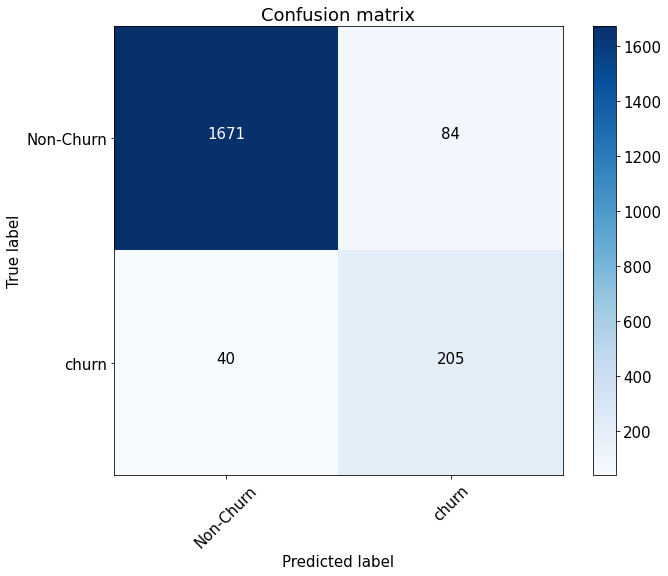

In [120]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [118]:
roc_auc_score(y_test, preds)

0.9684911913483342

In [ ]:
Комментарии: Точность и f-score при использовании функции max уменьшились,а полнота не изменилась.То есть,увеличилась доля
    FP( в 2 раза) и уменьшилась доля FN
    